# NOTEBOOK 02: SIGNAL QUALITY ANALYSIS & PREPROCESSING
 Purpose: Process usable records through full pipeline:
        - SQI assessment
        - Filtering & denoising
        - Segmentation (10-min windows)
        - Parquet conversion
Input: data/metadata/usable_records.parquet
Output:
  - data/processed/signals.npy (signal arrays)
  - data/processed/metadata.parquet (segment metadata)

Target: Process all usable records from Notebook 01(01_data_extraction)


## Set up

In [1]:
# Install dependencies (silent mode)
!pip install pandas==2.2.2 wfdb==4.1.2 mlflow pywavelets hydra-core pyarrow fastparquet neurokit2 comorbidipy requests -q

import os
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import wfdb
from datetime import datetime

# Set project root
PROJECT_ROOT = Path('/content/drive/MyDrive/cardiometabolic-risk-colab')
os.chdir(PROJECT_ROOT)
sys.path.insert(0, str(PROJECT_ROOT / 'colab_src'))

# 💻 Device
import torch
device_name = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device_name}")

print(f"✅ Environment ready")
print(f"   Working directory: {PROJECT_ROOT}")
print(f"   Timestamp: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.0/160.0 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 60.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 53.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 42.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 51.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 708.4/708.4 kB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.0/77.0 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.2/779.2

In [17]:
import mlflow
mlflow.end_run()

## Import Modules

In [2]:

# Cell 2: Import Modules (ALL from colab_src)
from data_pipeline import MIMICDataIngestor, SignalProcessingPipeline
from signal_processing import SignalQualityAssessor, PPGFilter, WaveletDenoiser, SignalSegmenter
from utils import ExperimentTracker, plot_signals, plot_sqi_distribution
from validation import DataQualityValidator

# Initialize components
ingestor = MIMICDataIngestor()
sqi_engine = SignalQualityAssessor(fs=125)
ppg_filter = PPGFilter(fs=125)
denoiser = WaveletDenoiser()
segmenter = SignalSegmenter(window_sec=600, fs=125)

tracker = ExperimentTracker()
run = tracker.start_run("signal_quality_analysis")

/usr/local/lib/python3.12/dist-packages/mlflow/tracking/_tracking_service/utils.py:178: FutureWarning: The filesystem tracking backend (e.g., './mlruns') will be deprecated in February 2026. Consider transitioning to a database backend (e.g., 'sqlite:///mlflow.db') to take advantage of the latest MLflow features. See https://github.com/mlflow/mlflow/issues/18534 for more details and migration guidance. For migrating existing data, https://github.com/mlflow/mlflow-export-import can be used.
  return FileStore(store_uri, store_uri)


## Load Usable Records

In [3]:
# Load Usable Records
usable_records = pd.read_parquet('data/metadata/usable_records.parquet')
print(f"Loaded {len(usable_records)} usable records")

Loaded 3225 usable records


### Pre-Filter for Corrupted Signals

In [4]:
# Fast NaN detection: Only check first 1 minute of each signal

from tqdm import tqdm
import numpy as np

print("Checking for corrupted signals (sampling first 60 seconds)...")
print(f"Initial count: {len(usable_records)}\n")

valid_records = []
corrupted_records = []
failed_downloads = []

# Progress bar
for idx, row in tqdm(usable_records.iterrows(), total=len(usable_records), desc="Validating"):
    record_name = row['record_name']

    try:
        # Parse record path
        record_name_only, pn_dir, subject_id = ingestor._parse_record_path(record_name)

        # READ ONLY FIRST 60 SECONDS (not entire signal)
        # This is 100x faster than downloading entire signal
        record = wfdb.rdrecord(
            record_name_only,
            pn_dir=pn_dir,
            sampfrom=0,           # Start from beginning
            sampto=7500           # Only read 60 sec @ 125 Hz
        )

        # Find PPG channel
        channel_idx = None
        for i, sig_name in enumerate(record.sig_name or []):
            if any(kw in sig_name.lower() for kw in ['pleth', 'ppg', 'photopleth']):
                channel_idx = i
                break

        if channel_idx is None:
            corrupted_records.append((record_name, "No PPG channel"))
            continue

        # Get signal sample
        signal_sample = record.p_signal[:, channel_idx]

        # Check for NaN
        if np.isnan(signal_sample).any():
            corrupted_records.append((record_name, "Contains NaN"))
            continue

        # Check for all zeros
        if np.all(signal_sample == 0):
            corrupted_records.append((record_name, "All zeros"))
            continue

        # Check for suspicious flatline (same value repeated)
        if len(np.unique(signal_sample)) < 10:
            corrupted_records.append((record_name, "Flatlined"))
            continue

        # Passed all checks
        valid_records.append(idx)

    except Exception as e:
        failed_downloads.append((record_name, str(e)[:50]))
        continue

# Update usable_records
usable_records_clean = usable_records.loc[valid_records].copy()
 # Save usable records
usable_records.to_parquet('data/metadata/usable_records.parquet', index=False)

print(f"\n{'='*70}")
print("VALIDATION RESULTS")
print(f"{'='*70}")
print(f"✅ Valid records: {len(usable_records_clean)}")
print(f"❌ Corrupted: {len(corrupted_records)}")
print(f"❌ Failed download: {len(failed_downloads)}")
print(f"📊 Success rate: {len(usable_records_clean)/len(usable_records)*100:.1f}%")

if len(corrupted_records) > 0:
    print(f"\n⚠️  Corruption breakdown:")
    corruption_types = {}
    for rec, reason in corrupted_records:
        corruption_types[reason] = corruption_types.get(reason, 0) + 1

    for reason, count in corruption_types.items():
        print(f"   {reason}: {count}")

    print(f"\n   Sample corrupted records (first 5):")
    for rec, reason in corrupted_records[:5]:
        print(f"   - {rec}: {reason}")

if len(failed_downloads) > 0:
    print(f"\n⚠️  Failed downloads (first 5):")
    for rec, error in failed_downloads[:5]:
        print(f"   - {rec}: {error}")

# Save corruption log
corruption_log = pd.DataFrame(corrupted_records + failed_downloads,
                             columns=['record_name', 'reason'])
corruption_log.to_csv('data/metadata/corrupted_records.csv', index=False)
print(f"\n💾 Corruption log saved: data/metadata/corrupted_records.csv")

# Replace with clean version
usable_records = usable_records_clean
# # Save usable records
# usable_records.to_parquet('data/metadata/usable_records.parquet', index=False)


print(f"\n✅ Ready to process {len(usable_records)} clean records")
print(f"{'='*70}")

Checking for corrupted signals (sampling first 60 seconds)...
Initial count: 3225



Validating: 100%|██████████| 3225/3225 [20:19<00:00,  2.64it/s]



VALIDATION RESULTS
✅ Valid records: 2021
❌ Corrupted: 1204
❌ Failed download: 0
📊 Success rate: 62.7%

⚠️  Corruption breakdown:
   Contains NaN: 1065
   Flatlined: 139

   Sample corrupted records (first 5):
   - p00/p000052/3533390_0001: Contains NaN
   - p00/p000052/3533390_0003: Contains NaN
   - p00/p000052/3533390_0015: Contains NaN
   - p00/p000052/3533390_0017: Flatlined
   - p00/p000107/3746356_0008: Contains NaN

💾 Corruption log saved: data/metadata/corrupted_records.csv

✅ Ready to process 2021 clean records


## Test Pipeline on single records

### Signal Quality Test

In [5]:
# Cell 3.5: Diagnostic - Check Signal Quality Before Pipeline

test_record = usable_records['record_name'].iloc[0]
print(f"Diagnosing: {test_record}\n")

# Download raw signal
signal_data = ingestor.download_signal(test_record)

if signal_data:
    raw = signal_data['signal']
    fs_orig = signal_data['fs']

    print(f"✅ Signal downloaded")
    print(f"   Length: {len(raw):,} samples")
    print(f"   Duration: {len(raw)/fs_orig/60:.1f} min")
    print(f"   Sampling rate: {fs_orig} Hz")
    print(f"   Range: [{raw.min():.2f}, {raw.max():.2f}]")
    print(f"   Mean: {raw.mean():.2f}")
    print(f"   Std: {raw.std():.2f}")

    # Resample if needed
    if fs_orig != 125:
        raw = ppg_filter.resample_signal(raw, fs_orig, 125)

    # Check SQI on raw signal (no preprocessing)
    print(f"\n📊 Raw Signal Quality Check:")

    # Test first 10-min window
    window_samples = 600 * 125  # 10 min
    if len(raw) >= window_samples:
        first_window = raw[:window_samples]
        sqi_result = sqi_engine.compute_sqi(first_window)

        print(f"   SQI Score: {sqi_result['sqi_score']:.3f}")
        print(f"   Quality Grade: {sqi_result['quality_grade']}")
        print(f"   SNR: {sqi_result['snr_db']:.1f} dB")
        print(f"   Perfusion Index: {sqi_result['perfusion_index']:.2f}%")
        print(f"   Flatline: {sqi_result['is_flatline']}")
        print(f"   Saturated: {sqi_result['is_saturated']}")

        if sqi_result['sqi_score'] < 0.5:
            print(f"\n⚠️  Signal quality is POOR (SQI < 0.5)")
            print(f"   This record will be rejected by pipeline")
        else:
            print(f"\n✅ Signal quality is ACCEPTABLE")
    else:
        print(f"   ⚠️  Signal too short for 10-min window")
else:
    print("❌ Failed to download signal")

Diagnosing: p00/p000052/3238451_0005

✅ Signal downloaded
   Length: 3,869,120 samples
   Duration: 515.9 min
   Sampling rate: 125 Hz
   Range: [0.00, 1.00]
   Mean: 0.43
   Std: 0.16

📊 Raw Signal Quality Check:
   SQI Score: 0.964
   Quality Grade: Excellent
   SNR: 35.8 dB
   Perfusion Index: 228.71%
   Flatline: False
   Saturated: False

✅ Signal quality is ACCEPTABLE


### Checking Segmentation and Window-Level SQI

In [6]:
# COMPLETE DIAGNOSTIC: Pipeline Debug

import numpy as np

# Select test record
test_record = usable_records['record_name'].iloc[0]
print(f"Analyzing: {test_record}\n")

# Step 1: Download signal
signal_data = ingestor.download_signal(test_record)

if not signal_data:
    print("❌ Failed to download")
else:
    raw = signal_data['signal']
    fs_orig = signal_data['fs']

    print(f"✅ Downloaded: {len(raw):,} samples, {len(raw)/fs_orig/60:.1f} min\n")

    # Step 2: Resample if needed
    if fs_orig != 125:
        raw = ppg_filter.resample_signal(raw, fs_orig, 125)
        print(f"✅ Resampled to 125 Hz")

    # Step 3: Filter
    filtered = ppg_filter.apply(raw)
    print(f"✅ Filtered")

    # Step 4: Denoise
    denoised = denoiser.denoise(filtered)
    print(f"✅ Denoised")


    # SEGMENTATION ANALYSIS

    print("\n" + "="*70)
    print("SEGMENTATION ANALYSIS")
    print("="*70)

    print(f"\nDenoised signal length: {len(denoised):,} samples")
    print(f"Duration: {len(denoised)/125/60:.1f} min")

    # Calculate possible windows
    window_samples = 600 * 125  # 10 min
    n_possible_windows = len(denoised) // window_samples

    print(f"Possible 10-min windows: {n_possible_windows}")

    # Check SQI for each window
    print(f"\n📊 SQI per 10-min window:")
    window_sqis = []

    for i in range(min(n_possible_windows, 10)):  # Limit to first 10 for readability
        start = i * window_samples
        end = start + window_samples
        window = denoised[start:end]

        sqi = sqi_engine.compute_sqi(window)
        window_sqis.append(sqi['sqi_score'])

        status = "✅ PASS" if sqi['sqi_score'] >= 0.5 else "❌ FAIL"
        print(f"   Window {i+1:2d}: SQI={sqi['sqi_score']:.3f} {status}")

        # Show details for failed windows
        if sqi['sqi_score'] < 0.5:
            print(f"              SNR={sqi['snr_db']:.1f}dB, PI={sqi['perfusion_index']:.1f}%, "
                  f"Flat={sqi['is_flatline']}, Sat={sqi['is_saturated']}")

    if n_possible_windows > 10:
        print(f"   ... ({n_possible_windows - 10} more windows)")

        # Check all remaining windows
        for i in range(10, n_possible_windows):
            start = i * window_samples
            end = start + window_samples
            window = denoised[start:end]
            sqi = sqi_engine.compute_sqi(window)
            window_sqis.append(sqi['sqi_score'])

    # Summary statistics
    print(f"\n📊 Summary (all {len(window_sqis)} windows):")
    print(f"   Mean SQI: {np.mean(window_sqis):.3f}")
    print(f"   Min SQI:  {np.min(window_sqis):.3f}")
    print(f"   Max SQI:  {np.max(window_sqis):.3f}")
    print(f"   Passing (≥0.5): {sum(s >= 0.5 for s in window_sqis)}/{len(window_sqis)}")


    # TEST ACTUAL SEGMENTER

    print(f"\n" + "="*70)
    print("TESTING PIPELINE SEGMENTER")
    print("="*70)

    segments_with_sqi = segmenter.segment_with_sqi(denoised, sqi_engine, min_sqi=0.5)

    print(f"\nSegmenter returned: {len(segments_with_sqi)} segments")
    print(f"Manual count:       {sum(s >= 0.5 for s in window_sqis)} windows")

    # Check for mismatch
    if len(segments_with_sqi) != sum(s >= 0.5 for s in window_sqis):
        print(f"\n⚠️  MISMATCH DETECTED!")
        print(f"\n🐛 Possible causes:")
        print(f"   1. Segmenter has different window size")
        print(f"   2. Segmenter has overlap (not expected)")
        print(f"   3. Bug in segment_with_sqi() logic")

        # Show what segmenter actually returned
        if len(segments_with_sqi) > 0:
            print(f"\n   Segmenter returned segments with SQI:")
            for i, (seg, sqi_data) in enumerate(segments_with_sqi[:5]):
                print(f"      Seg {i+1}: SQI={sqi_data['sqi_score']:.3f}, len={len(seg)}")

    elif len(segments_with_sqi) == 0:
        print(f"\n❌ NO SEGMENTS ACCEPTED")
        print(f"\n💡 Why:")
        if sum(s >= 0.5 for s in window_sqis) == 0:
            print(f"   All windows failed SQI threshold (max SQI: {max(window_sqis):.3f})")
            print(f"   → Preprocessing is degrading signal quality")
            print(f"   → Try lowering threshold to 0.3 or adjusting filters")
        else:
            print(f"   Windows passed manually but segmenter rejected them")
            print(f"   → Bug in segmenter code")

    else:
        print(f"\n✅ MATCH - Segmenter working correctly")
        print(f"   {len(segments_with_sqi)} segments accepted")

        # Show first few segment SQIs
        print(f"\n   First 5 segment SQIs:")
        for i, (seg, sqi_data) in enumerate(segments_with_sqi[:5]):
            print(f"      Segment {i+1}: {sqi_data['sqi_score']:.3f}")


Analyzing: p00/p000052/3238451_0005

✅ Downloaded: 3,869,120 samples, 515.9 min

✅ Filtered
✅ Denoised

SEGMENTATION ANALYSIS

Denoised signal length: 3,869,120 samples
Duration: 515.9 min
Possible 10-min windows: 51

📊 SQI per 10-min window:
   Window  1: SQI=0.880 ✅ PASS
   Window  2: SQI=0.875 ✅ PASS
   Window  3: SQI=0.628 ✅ PASS
   Window  4: SQI=0.863 ✅ PASS
   Window  5: SQI=0.690 ✅ PASS
   Window  6: SQI=0.859 ✅ PASS
   Window  7: SQI=0.867 ✅ PASS
   Window  8: SQI=0.876 ✅ PASS
   Window  9: SQI=0.870 ✅ PASS
   Window 10: SQI=0.857 ✅ PASS
   ... (41 more windows)

📊 Summary (all 51 windows):
   Mean SQI: 0.829
   Min SQI:  0.628
   Max SQI:  0.889
   Passing (≥0.5): 51/51

TESTING PIPELINE SEGMENTER

Segmenter returned: 51 segments
Manual count:       51 windows

✅ MATCH - Segmenter working correctly
   51 segments accepted

   First 5 segment SQIs:
      Segment 1: 0.880
      Segment 2: 0.875
      Segment 3: 0.628
      Segment 4: 0.863
      Segment 5: 0.690


In [7]:
# Test Pipeline on Single Record

pipeline = SignalProcessingPipeline(
    ingestor=ingestor,
    sqi_engine=sqi_engine,
    ppg_filter=ppg_filter,
    denoiser=denoiser,
    segmenter=segmenter
)

test_record = usable_records['record_name'].iloc[0]
print(f"Testing pipeline on: {test_record}")

test_segments = pipeline.process_single_record(test_record, min_sqi=0.5)

print(f"\n✅ Pipeline test successful")
print(f"   Segments accepted: {len(test_segments)}")

if len(test_segments) > 0:
    print(f"   First segment SQI: {test_segments[0]['sqi_score']:.3f}")
    print(f"   Signal shape: {test_segments[0]['signal'].shape}")

Testing pipeline on: p00/p000052/3238451_0005

✅ Pipeline test successful
   Segments accepted: 51
   First segment SQI: 0.880
   Signal shape: (75000,)


In [ ]:
# records instead of just 1
print("Testing first 5 records...\n")

for i in range(min(5, len(usable_records))):
    test_record = usable_records['record_name'].iloc[i]
    print(f"[{i+1}/5] {test_record}")

    test_segments = pipeline.process_single_record(test_record, min_sqi=0.5)
    print(f"   Segments: {len(test_segments)}")

    if len(test_segments) > 0:
        print(f"   SQI: {test_segments[0]['sqi_score']:.3f}")
        print(f"   ✅ This record works!\n")
        break
    else:
        print(f"   ❌ No segments accepted\n")

### Comapring SQI before and after preprocessing

In [8]:
# Compare SQI before and after preprocessing

signal_data = ingestor.download_signal(test_record)
raw = signal_data['signal']

# Resample
if signal_data['fs'] != 125:
    raw = ppg_filter.resample_signal(raw, signal_data['fs'], 125)

# Check quality at each step
print("SQI at each preprocessing stage:\n")

# Raw
window = raw[:75000]  # 10 min
sqi_raw = sqi_engine.compute_sqi(window)
print(f"1. Raw signal: {sqi_raw['sqi_score']:.3f}")

# After filtering
filtered = ppg_filter.apply(raw)
window_filtered = filtered[:75000]
sqi_filtered = sqi_engine.compute_sqi(window_filtered)
print(f"2. After filter: {sqi_filtered['sqi_score']:.3f}")

# After denoising
denoised = denoiser.denoise(filtered)
window_denoised = denoised[:75000]
sqi_denoised = sqi_engine.compute_sqi(window_denoised)
print(f"3. After denoise: {sqi_denoised['sqi_score']:.3f}")

print(f"\nSQI change: {sqi_raw['sqi_score']:.3f} → {sqi_denoised['sqi_score']:.3f}")
if sqi_denoised['sqi_score'] < sqi_raw['sqi_score'] * 0.8:
    print("⚠️  Preprocessing degraded signal quality by >20%")

SQI at each preprocessing stage:

1. Raw signal: 0.964
2. After filter: 0.880
3. After denoise: 0.880

SQI change: 0.964 → 0.880


## Visualize Preprocessing steps

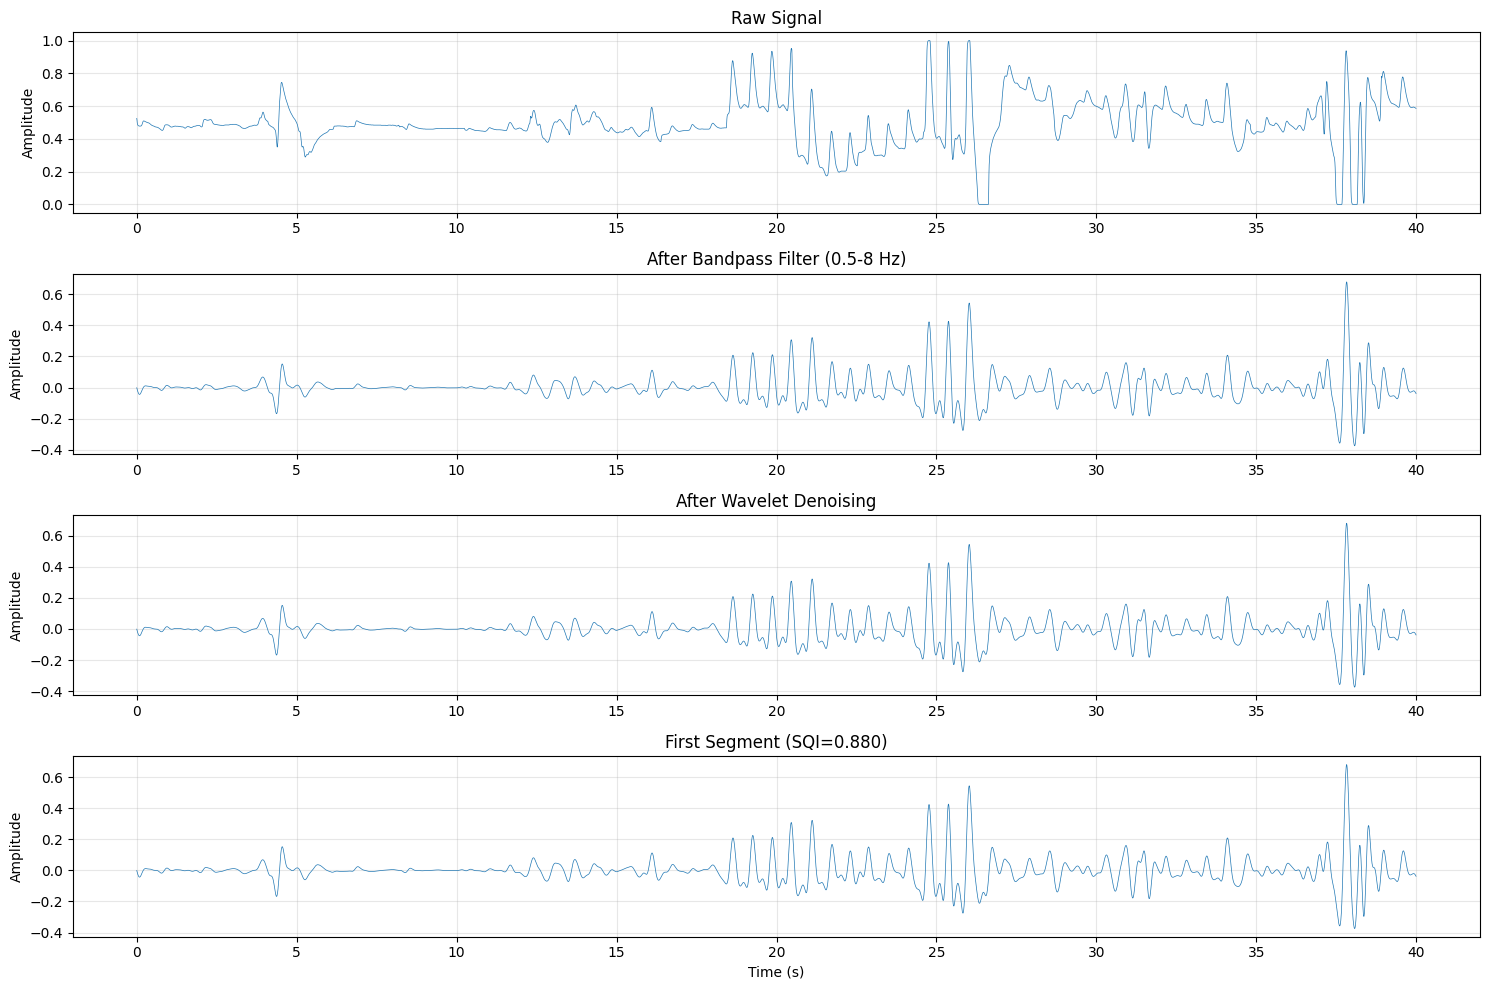

In [9]:
# Visualize Preprocessing Steps (on test record)
# Download raw signal for visualization
import matplotlib.pyplot as plt
signal_data = ingestor.download_signal(test_record)

if signal_data:
    raw = signal_data['signal']
    fs_orig = signal_data['fs']

    if fs_orig != 125:
        raw = ppg_filter.resample_signal(raw, fs_orig, 125)

    filtered = ppg_filter.apply(raw)
    denoised = denoiser.denoise(filtered)

    fig, axes = plt.subplots(4, 1, figsize=(15, 10))

    time = np.arange(min(5000, len(raw))) / 125

    axes[0].plot(time, raw[:len(time)], linewidth=0.5)
    axes[0].set_title("Raw Signal")
    axes[0].set_ylabel("Amplitude")
    axes[0].grid(alpha=0.3)

    axes[1].plot(time, filtered[:len(time)], linewidth=0.5)
    axes[1].set_title("After Bandpass Filter (0.5-8 Hz)")
    axes[1].set_ylabel("Amplitude")
    axes[1].grid(alpha=0.3)

    axes[2].plot(time, denoised[:len(time)], linewidth=0.5)
    axes[2].set_title("After Wavelet Denoising")
    axes[2].set_ylabel("Amplitude")
    axes[2].grid(alpha=0.3)

    if len(test_segments) > 0:
        seg_time = np.arange(min(5000, len(test_segments[0]['signal']))) / 125
        axes[3].plot(seg_time, test_segments[0]['signal'][:len(seg_time)], linewidth=0.5)
        axes[3].set_title(f"First Segment (SQI={test_segments[0]['sqi_score']:.3f})")

    axes[3].set_xlabel("Time (s)")
    axes[3].set_ylabel("Amplitude")
    axes[3].grid(alpha=0.3)

    plt.tight_layout()
    plt.savefig('data/processed/preprocessing_pipeline_viz.png', dpi=150)
    plt.show()

### Reimport modules

In [10]:
# Re-create the pipeline object to pick up new methods
from data_pipeline import MIMICDataIngestor, SignalProcessingPipeline
pipeline = SignalProcessingPipeline(
    ingestor=ingestor,
    sqi_engine=sqi_engine,
    ppg_filter=ppg_filter,
    denoiser=denoiser,
    segmenter=segmenter
)

# Verify the method exists
print(f"✅ Pipeline has load_and_filter_batches: {hasattr(pipeline, 'load_and_filter_batches')}")
print(f"✅ Pipeline has process_batch_parallel: {hasattr(pipeline, 'process_batch_parallel')}")

✅ Pipeline has load_and_filter_batches: True
✅ Pipeline has process_batch_parallel: True



## Process ALL Records in Batches (with Checkpoints)

 Process in batches of 50 with intermediate saves
 Allows resume if Colab disconnects during long processing

In [11]:
# OPTIMIZED PARALLEL BATCH PROCESSING WITH TOP-K SQI FILTERING

import pandas as pd
import numpy as np
from pathlib import Path
import gc
from datetime import datetime
from concurrent.futures import ProcessPoolExecutor, as_completed

print("="*70)
print(f"OPTIMIZED PARALLEL BATCH PROCESSING")
print("="*70)

# ===== CONFIGURATION =====
BATCH_SIZE = 50                # Records per batch
MIN_SQI = 0.5                  # Minimum quality threshold
TOP_K_SEGMENTS = 3             # Keep only top-3 segments per record (HUGE space savings)
MAX_WORKERS = 4                # Parallel workers

checkpoint_dir = Path('data/processed/checkpoints')
signals_dir = Path('data/processed/batch_signals')

# Create directories
checkpoint_dir.mkdir(parents=True, exist_ok=True)
signals_dir.mkdir(parents=True, exist_ok=True)

# Get batch records
batch_records = usable_records['record_name'].tolist()
total_batches = (len(batch_records) - 1) // BATCH_SIZE + 1

print(f"\n📋 Configuration:")
print(f"   Total records: {len(batch_records)}")
print(f"   Batch size: {BATCH_SIZE}")
print(f"   Total batches: {total_batches}")
print(f"   Min SQI: {MIN_SQI}")
print(f"   Top-K segments per record: {TOP_K_SEGMENTS}")
print(f"   Parallel workers: {MAX_WORKERS}")
print(f"   Expected segments: ~{len(batch_records) * TOP_K_SEGMENTS}")

# ===== RESUME FROM CHECKPOINTS =====
print(f"\n🔍 Checking for existing checkpoints...")
existing_checkpoints = sorted(checkpoint_dir.glob('batch_*_metadata.parquet'))
completed_batches = set()

if existing_checkpoints:
    for ckpt in existing_checkpoints:
        batch_num = int(ckpt.stem.split('_')[1])
        completed_batches.add(batch_num)

    print(f"   ✅ Found {len(completed_batches)} completed batches")
    print(f"   Resuming from batch {max(completed_batches) + 1}")
else:
    print(f"   Starting fresh (no checkpoints found)")

# ===== STATISTICS TRACKING =====
total_segments_accepted = 0
total_records_processed = 0
start_time = datetime.now()

print(f"\n{'='*70}")
print(f"STARTING PARALLEL PROCESSING")
print(f"{'='*70}\n")

# ===== BATCH PROCESSING LOOP =====
for batch_idx in range(0, len(batch_records), BATCH_SIZE):
    batch_num = batch_idx // BATCH_SIZE + 1

    # Skip if already completed
    if batch_num in completed_batches:
        print(f"⏭️  BATCH {batch_num}/{total_batches}: Already completed (skipping)")
        continue

    batch = batch_records[batch_idx:batch_idx + BATCH_SIZE]

    print(f"\n{'='*70}")
    print(f"BATCH {batch_num}/{total_batches}")
    print(f"{'='*70}")
    print(f"Processing {len(batch)} records in parallel ({MAX_WORKERS} workers)...")

    try:
        # ===== PARALLEL PROCESSING WITH TOP-K FILTERING =====
        batch_segments = pipeline.process_batch_parallel(
            batch,
            min_sqi=MIN_SQI,
            top_k=TOP_K_SEGMENTS,
            max_workers=MAX_WORKERS,
            show_progress=True
        )

        if len(batch_segments) == 0:
            print(f"   ⚠️  No segments accepted in this batch")
            continue

        # ===== SEPARATE SIGNALS FROM METADATA =====
        batch_signals = np.array([seg['signal'] for seg in batch_segments])
        batch_metadata = pd.DataFrame([
            {k: v for k, v in seg.items() if k != 'signal'}
            for seg in batch_segments
        ])

        # Add global segment indices
        batch_metadata['global_segment_idx'] = range(
            total_segments_accepted,
            total_segments_accepted + len(batch_segments)
        )
        batch_metadata['batch_num'] = batch_num

        # ===== SAVE SIGNALS IMMEDIATELY =====
        signals_file = signals_dir / f'batch_{batch_num:03d}_signals.npy'
        np.save(signals_file, batch_signals)

        # ===== SAVE METADATA CHECKPOINT =====
        checkpoint_file = checkpoint_dir / f'batch_{batch_num:03d}_metadata.parquet'
        batch_metadata.to_parquet(checkpoint_file, index=False, compression='snappy')

        # ===== UPDATE STATISTICS =====
        total_segments_accepted += len(batch_segments)
        total_records_processed += len(batch)

        # ===== PROGRESS REPORT =====
        elapsed = (datetime.now() - start_time).total_seconds()
        avg_time_per_batch = elapsed / (batch_num - len(completed_batches))
        remaining_batches = total_batches - batch_num
        eta_seconds = avg_time_per_batch * remaining_batches
        eta_minutes = eta_seconds / 60

        print(f"\n📊 Batch Results:")
        print(f"   Segments accepted: {len(batch_segments)}")
        print(f"   Mean SQI: {batch_metadata['sqi_score'].mean():.3f}")
        print(f"   Segments/record: {len(batch_segments)/len(batch):.1f}")
        print(f"   💾 Saved: {signals_file.name}")
        print(f"   💾 Checkpoint: {checkpoint_file.name}")

        print(f"\n📊 Cumulative Progress:")
        print(f"   Total segments: {total_segments_accepted}")
        print(f"   Records processed: {total_records_processed}/{len(batch_records)}")
        print(f"   Batches complete: {batch_num}/{total_batches} ({batch_num/total_batches*100:.1f}%)")
        print(f"   ⏱️  ETA: {eta_minutes:.1f} minutes")
        print(f"   ⚡ Throughput: {total_records_processed/elapsed*60:.1f} records/min")

        # ===== CRITICAL: CLEAR MEMORY =====
        del batch_segments
        del batch_signals
        del batch_metadata
        gc.collect()

    except Exception as e:
        print(f"\n❌ Batch {batch_num} FAILED: {str(e)[:150]}")
        print(f"   Continuing to next batch...")
        continue
# ===== FINAL ASSEMBLY WITH FILTERING =====
print(f"\n{'='*70}")
print(f"ASSEMBLING AND FILTERING FINAL DATASET")
print(f"{'='*70}")

# Configuration for filtering
TOP_K_PER_RECORD = 3      # Keep only best 3 segments per record
MIN_SQI_FINAL = 0.7       # Higher quality threshold for final dataset

# Check if we have any batch files to load
checkpoint_files = sorted(checkpoint_dir.glob('batch_*_metadata.parquet'))
signals_files = sorted(signals_dir.glob('batch_*_signals.npy'))

if len(checkpoint_files) == 0:
    print("⚠️  No checkpoint files found. Nothing to assemble.")
    print("   Run the batch processing first to generate data.")
else:
    # Use the pipeline's smart assembly method
    result = pipeline.load_and_filter_batches(
        checkpoint_dir=checkpoint_dir,
        signals_dir=signals_dir,
        top_k_per_record=TOP_K_PER_RECORD,
        min_sqi=MIN_SQI_FINAL
    )

    final_signals = result['signals']
    final_metadata = result['metadata']
    stats = result['stats']

    # ===== SAVE FINAL CONSOLIDATED FILES =====
    print(f"\n💾 Saving final consolidated files...")

    final_signals_path = 'data/processed/sprint1_signals.npy'
    final_metadata_path = 'data/processed/sprint1_metadata.parquet'

    np.save(final_signals_path, final_signals)
    final_metadata.to_parquet(final_metadata_path, index=False, compression='snappy')

    print(f"   ✅ {final_signals_path} ({stats['size_mb']:.1f} MB)")
    print(f"   ✅ {final_metadata_path}")

    # ===== LOG TO MLFLOW (if tracker exists) =====
    try:
        tracker.log_params({
            'n_input_records': len(batch_records),
            'n_segments_accepted': stats['total_segments'],
            'min_sqi_threshold': MIN_SQI,
            'min_sqi_final': MIN_SQI_FINAL,
            'top_k_per_record': TOP_K_PER_RECORD,
            'window_sec': 600
        })

        tracker.log_metrics({
            'mean_sqi': stats['mean_sqi'],
            'median_sqi': stats['median_sqi'],
            'unique_subjects': stats['unique_subjects'],
            'acceptance_rate': stats['total_segments'] / len(batch_records),
            'size_reduction_pct': stats['reduction_pct']
        })
        print(f"\n✅ Logged to MLflow")
    except NameError:
        print(f"\n⚠️  MLflow tracker not initialized (skipping logging)")

    # ===== FINAL STATISTICS =====
    total_time = (datetime.now() - start_time).total_seconds() / 60

    print(f"\n{'='*70}")
    print(f"PROCESSING COMPLETE")
    print(f"{'='*70}")
    print(f"✅ Total segments: {stats['total_segments']:,}")
    print(f"   Records in final dataset: {stats['unique_records']}")
    print(f"   Segments per record: {stats['total_segments']/stats['unique_records']:.1f}")
    print(f"   Total time: {total_time:.1f} minutes")
    print(f"   Average: {total_time/total_batches:.1f} min/batch")
    print(f"   Throughput: {len(batch_records)/total_time:.1f} records/min")
    print(f"\n📊 Quality:")
    print(f"   Mean SQI: {stats['mean_sqi']:.3f}")
    print(f"   Median SQI: {stats['median_sqi']:.3f}")
    print(f"   Min SQI: {stats['min_sqi']:.3f}")
    print(f"   Unique subjects: {stats['unique_subjects']}")
    print(f"\n💾 Dataset:")
    print(f"   Size: {stats['size_mb']:.1f} MB")
    print(f"   Reduction: {stats['reduction_pct']:.1f}%")
    print(f"   Shape: {final_signals.shape}")
    print(f"{'='*70}")

OPTIMIZED PARALLEL BATCH PROCESSING

📋 Configuration:
   Total records: 2021
   Batch size: 50
   Total batches: 41
   Min SQI: 0.5
   Top-K segments per record: 3
   Parallel workers: 4
   Expected segments: ~6063

🔍 Checking for existing checkpoints...
   ✅ Found 41 completed batches
   Resuming from batch 42

STARTING PARALLEL PROCESSING

⏭️  BATCH 1/41: Already completed (skipping)
⏭️  BATCH 2/41: Already completed (skipping)
⏭️  BATCH 3/41: Already completed (skipping)
⏭️  BATCH 4/41: Already completed (skipping)
⏭️  BATCH 5/41: Already completed (skipping)
⏭️  BATCH 6/41: Already completed (skipping)
⏭️  BATCH 7/41: Already completed (skipping)
⏭️  BATCH 8/41: Already completed (skipping)
⏭️  BATCH 9/41: Already completed (skipping)
⏭️  BATCH 10/41: Already completed (skipping)
⏭️  BATCH 11/41: Already completed (skipping)
⏭️  BATCH 12/41: Already completed (skipping)
⏭️  BATCH 13/41: Already completed (skipping)
⏭️  BATCH 14/41: Already completed (skipping)
⏭️  BATCH 15/41: Alre

In [12]:
# Run this once to clean up incomplete batches
import shutil
from pathlib import Path

checkpoint_dir = Path('data/processed/checkpoints')
signals_dir = Path('data/processed/batch_signals')

# Find batches with metadata but no signals
checkpoint_files = set(int(f.stem.split('_')[1]) for f in checkpoint_dir.glob('batch_*_metadata.parquet'))
signal_files = set(int(f.stem.split('_')[1]) for f in signals_dir.glob('batch_*_signals.npy'))

incomplete_batches = checkpoint_files - signal_files

if incomplete_batches:
    print(f"Found {len(incomplete_batches)} incomplete batches: {sorted(incomplete_batches)}")

    for batch_num in incomplete_batches:
        ckpt_file = checkpoint_dir / f'batch_{batch_num:03d}_metadata.parquet'
        if ckpt_file.exists():
            ckpt_file.unlink()
            print(f"   🗑️  Deleted {ckpt_file.name}")

    print(f"\n✅ Cleaned up incomplete batches. They will be reprocessed.")
else:
    print("✅ No incomplete batches found")

✅ No incomplete batches found


batch 4, 3, 6, 7, 12, 9,8, 21, 22, 11

## Visualizations

### Data Quality Validation

In [13]:
# Validate Processed Data

from validation import DataQualityValidator

print("="*70)
print("DATA QUALITY VALIDATION")
print("="*70)

validator = DataQualityValidator(
    signals_path='data/processed/sprint1_signals.npy',
    metadata_path='data/processed/sprint1_metadata.parquet'
)

validation_passed = validator.run_all_tests()

if validation_passed:
    print("\n✅ All validation tests passed - data ready for Sprint 2")
else:
    print("\n⚠️  Some validation tests failed - review above")

DATA QUALITY VALIDATION
DATA QUALITY VALIDATION
✅ Schema Test: All required columns present
✅ Signal Shape: (4417, 75000) (correct)
✅ SQI Distribution: Mean=0.958, Min=0.730
❌ NaN Test: Found 0 signal NaNs, 776 metadata NaNs
✅ Signal Range: Min=-3.77, Max=3.57
✅ Sampling Rate: Consistent at 125 Hz

RESULT: 5/6 tests passed


⚠️  Some validation tests failed - review above


### Data Quality Distribution

QUALITY DISTRIBUTION ANALYSIS


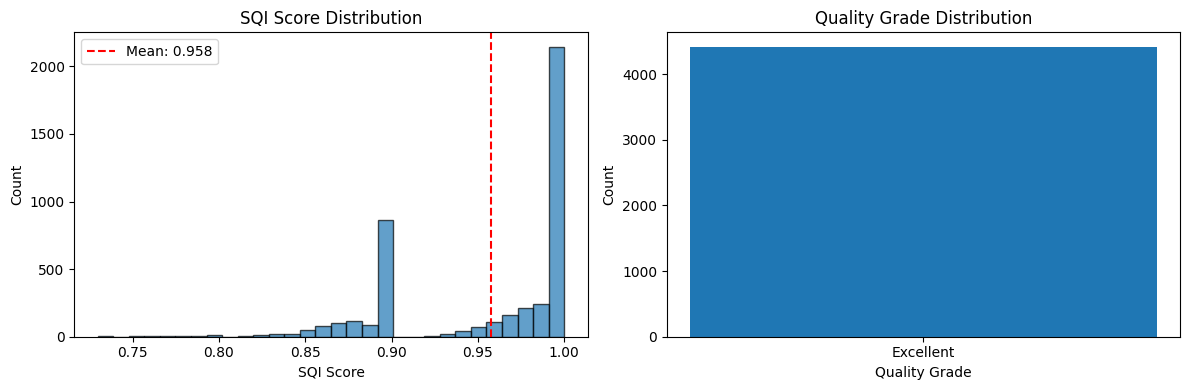


📊 Quality Grade Distribution:
quality_grade
Excellent    4417
Name: count, dtype: int64

📊 SNR Distribution:
count    4417.000000
mean       40.660759
std         3.916753
min        29.426447
25%        38.090908
50%        40.534623
75%        42.518369
max        58.476201
Name: snr_db, dtype: float64

📊 Subject Coverage:
   Unique subjects: 130
   Segments per subject: count    130.000000
mean      33.976923
std       48.350219
min        1.000000
25%        7.000000
50%       15.000000
75%       35.750000
max      282.000000
dtype: float64


In [14]:
# Cell 9: Visualize Quality Distribution
from utils import plot_sqi_distribution
import matplotlib.pyplot as plt

print("="*70)
print("QUALITY DISTRIBUTION ANALYSIS")
print("="*70)

# Load metadata
metadata = pd.read_parquet('data/processed/sprint1_metadata.parquet')

# Plot SQI distribution
fig = plot_sqi_distribution(
    metadata,
    save_path='data/processed/sqi_distribution.png'
)
plt.show()

# Additional statistics
print("\n📊 Quality Grade Distribution:")
print(metadata['quality_grade'].value_counts())

print("\n📊 SNR Distribution:")
print(metadata['snr_db'].describe())

print("\n📊 Subject Coverage:")
subject_counts = metadata['subject_id'].value_counts()
print(f"   Unique subjects: {len(subject_counts)}")
print(f"   Segments per subject: {metadata.groupby('subject_id').size().describe()}")

# Log visualization
tracker.log_artifact('data/processed/sqi_distribution.png')

### Sample Signal Visualization

SAMPLE SIGNAL VISUALIZATION


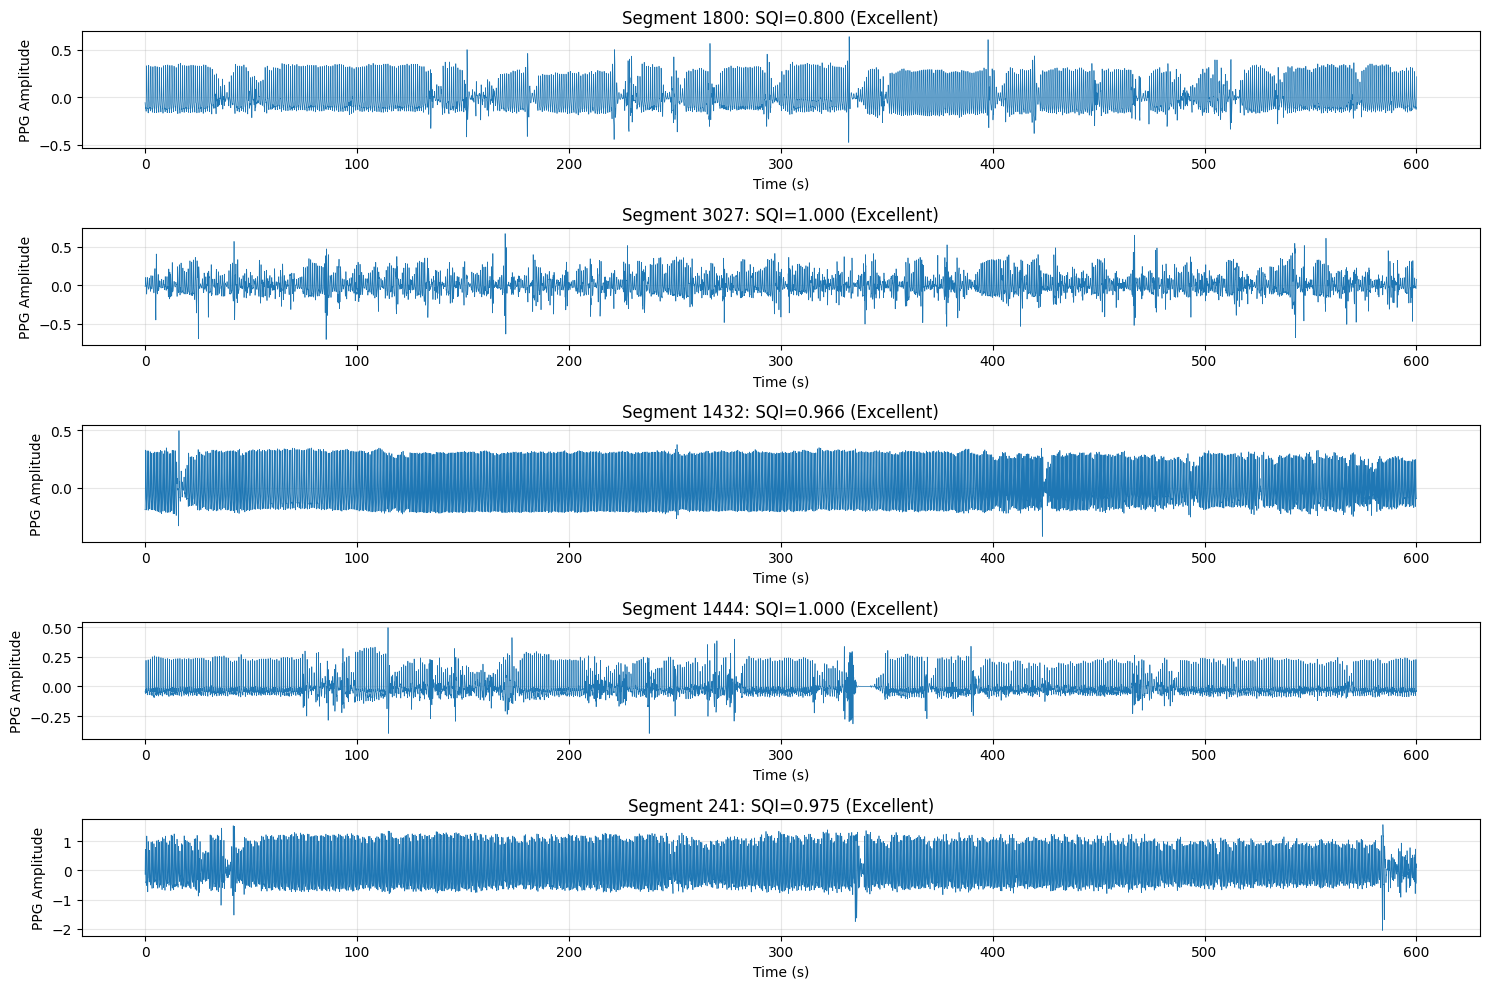


💾 Saved: data/processed/sample_signals.png


In [15]:
# Cell 10: Visualize Sample Preprocessed Signals

from utils import plot_signals

print("="*70)
print("SAMPLE SIGNAL VISUALIZATION")
print("="*70)

# Load signals and metadata
signals = np.load('data/processed/sprint1_signals.npy')
metadata = pd.read_parquet('data/processed/sprint1_metadata.parquet')

# Plot 5 random samples
fig = plot_signals(
    signals,
    metadata,
    n_samples=5,
    figsize=(15, 10)
)
plt.savefig('data/processed/sample_signals.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n💾 Saved: data/processed/sample_signals.png")

# Log artifact
tracker.log_artifact('data/processed/sample_signals.png')

## Clean Up Temporary Files

In [22]:
 # ===== OPTIONAL CLEANUP =====
    # Uncomment to delete temporary batch files after consolidation
import shutil
from pathlib import Path

checkpoint_dir = Path('data/processed/checkpoints')
signals_dir = Path('data/processed/batch_signals')

shutil.rmtree(signals_dir)
shutil.rmtree(checkpoint_dir)
print(f"\n🧹 Cleaned up temporary batch files")


🧹 Cleaned up temporary batch files


## Processing Summary Report

In [30]:
# Cell 11: Generate Summary Report

from datetime import datetime

print("\n" + "="*70)
print("SPRINT 1 - SIGNAL PROCESSING SUMMARY")
print("="*70)

print(f"\n📅 Timestamp: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

print(f"\n📊 INPUT DATA:")
print(f"   Records from Notebook 01: {len(batch_records)}")
print(f"   Mean record duration: {usable_records['duration_min'].mean():.1f} min")

print(f"\n📊 PROCESSING RESULTS:")
print(f"✅ Total segments: {stats['total_segments']:,}")
print(f"   Segments per record: {stats['total_segments']/len(batch_records):.1f} avg")
print(f"   Acceptance rate: {stats['total_segments']/len(batch_records)*100:.1f}%")

print(f"\n📊 QUALITY METRICS:")
sqi_scores = metadata['sqi_score']
print(f"   Mean SQI: {sqi_scores.mean():.3f}")
print(f"   Median SQI: {sqi_scores.median():.3f}")
print(f"   Min SQI: {sqi_scores.min():.3f}")
print(f"   Max SQI: {sqi_scores.max():.3f}")

print(f"\n📊 SIGNAL CHARACTERISTICS:")
print(f"   Segment duration: 10 minutes each")
print(f"   Sampling rate: 125 Hz")
print(f"   Samples per segment: 75,000")
print(f"   Total signal hours: {stats['total_segments'] * 10 / 60:.1f}")

print(f"\n📊 SUBJECT DISTRIBUTION:")
subject_counts = metadata['subject_id'].value_counts()
print(f"   Unique subjects: {len(subject_counts)}")
print(f"   Segments per subject: {stats['total_segments']/len(subject_counts):.1f} avg")
print(f"   Max from one subject: {subject_counts.max()}")
print(f"   Min from one subject: {subject_counts.min()}")

print(f"\n💾 OUTPUT FILES:")
print(f"   ✅ data/processed/sprint1_signals.npy ({signals.shape})")
print(f"   ✅ data/processed/sprint1_metadata.parquet ({metadata.shape})")
print(f"   ✅ data/processed/sqi_distribution.png")
print(f"   ✅ data/processed/sample_signals.png")
print(f"   ✅ {len(list(checkpoint_dir.glob('*.parquet')))} checkpoint files")

print(f"\n🎯 SPRINT 2 READINESS:")
if stats['total_segments'] >= 1000:
    print(f"   ✅ EXCELLENT: {stats['total_segments']} segments available")
    print(f"   → Ready for feature engineering")
    print(f"   → Expected features: ~{stats['total_segments'] * 49:,} total feature values")
elif stats['total_segments'] >= 500:
    print(f"   ✅ GOOD: {stats['total_segments']} segments available")
    print(f"   → Sufficient for model development")
elif stats['total_segments'] >= 100:
    print(f"   ⚠️  LIMITED: {stats['total_segments']} segments")
    print(f"   → May need more data for robust models")
    print(f"   → Consider lowering SQI threshold or scaling up")
else:
    print(f"   ❌ INSUFFICIENT: Only {stats['total_segments']} segments")
    print(f"   → Increase input records or lower SQI threshold")

print(f"\n🚀 NEXT STEPS:")
print(f"   1. Review quality visualizations")
print(f"   2. Proceed to Sprint 2: Feature Engineering")
print(f"   3. Extract 49 features per segment")
print(f"   4. Build baseline classification models")

print("\n" + "="*70)


SPRINT 1 - SIGNAL PROCESSING SUMMARY

📅 Timestamp: 2026-01-06 22:34:28

📊 INPUT DATA:
   Records from Notebook 01: 2021
   Mean record duration: 322.6 min

📊 PROCESSING RESULTS:
✅ Total segments: 4,417
   Segments per record: 2.2 avg
   Acceptance rate: 218.6%

📊 QUALITY METRICS:
   Mean SQI: 0.958
   Median SQI: 0.989
   Min SQI: 0.730
   Max SQI: 1.000

📊 SIGNAL CHARACTERISTICS:
   Segment duration: 10 minutes each
   Sampling rate: 125 Hz
   Samples per segment: 75,000
   Total signal hours: 736.2

📊 SUBJECT DISTRIBUTION:
   Unique subjects: 130
   Segments per subject: 34.0 avg
   Max from one subject: 282
   Min from one subject: 1

💾 OUTPUT FILES:
   ✅ data/processed/sprint1_signals.npy ((4417, 75000))
   ✅ data/processed/sprint1_metadata.parquet ((4417, 11))
   ✅ data/processed/sqi_distribution.png
   ✅ data/processed/sample_signals.png
   ✅ 0 checkpoint files

🎯 SPRINT 2 READINESS:
   ✅ EXCELLENT: 4417 segments available
   → Ready for feature engineering
   → Expected feature

## End MLflow Run

In [31]:
# Cell 12: Finalize Experiment Tracking

# End MLflow run
tracker.end_run()

print("✅ Sprint 1 Complete - Signal Processing")
print("   MLflow logs: logs/mlruns/")
print("\n📋 Deliverables:")
print("   ✓ Processed signals ready")
print("   ✓ Quality validated")
print("   ✓ Visualizations generated")
print("\n→ Ready for Notebook 03: Feature Engineering")

✅ Sprint 1 Complete - Signal Processing
   MLflow logs: logs/mlruns/

📋 Deliverables:
   ✓ Processed signals ready
   ✓ Quality validated
   ✓ Visualizations generated

→ Ready for Notebook 03: Feature Engineering
